In [1]:
import pandas as pd
import glob
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report

# Ładowanie danych

In [2]:
path = "scale_data/merged/"

all_files = glob.glob(path + "*")
# print(all_files)

def read_csv(f):
    return pd.read_csv(f, engine="python", delimiter="impossible_delimiter_to_read_line_by_line", names=[os.path.basename(f)])

def reset_index(df):
    df.reset_index(drop=True, inplace=True)

dataframes = [read_csv(f) for f in all_files]

df = pd.concat(dataframes, axis=1)

df.head()

,id,label_3class,label_4class,rating,subj
0,29420,0,0,0.1,"in my opinion , a movie reviewer's most import..."
1,17219,0,0,0.2,"you can watch this movie , that is based on a ..."
2,18406,0,0,0.2,"this is asking a lot to believe , and though i..."
3,18648,0,0,0.2,no heroes and no story are the main attributes...
4,20021,0,0,0.2,"this is not an art movie , yet i saw it an art..."


# Analiza danych
## Rozkład ocen

,label_3class,counts
0,0,1197
1,1,1915
2,2,1894


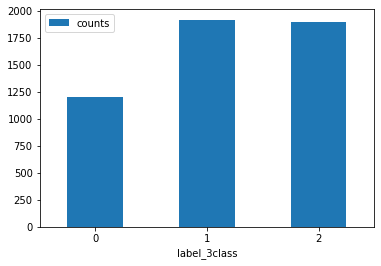

In [3]:
c = df.groupby('label_3class').size().reset_index(name='counts')
c.plot.bar(x='label_3class', y="counts", rot=0)
c

,label_4class,counts
0,0,615
1,1,1553
2,2,1998
3,3,840


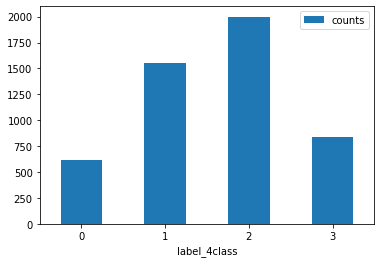

In [4]:
c = df.groupby('label_4class').size().reset_index(name='counts')
c.plot.bar(x='label_4class', y="counts", rot=0)
c

## Typowe długości recenzji

In [5]:
subj_len_list = df.subj.map(len)

print('Przeciętna długość recenzji: ' + str(subj_len_list.mean()))

subj_len_list.reset_index(name='len')[['len']].groupby('len').size().T.sort_values(ascending=False).head(15).reset_index(name='count')

Przeciętna długość recenzji: 2256.4578505793047


,len,count
0,2414,8
1,1717,8
2,2146,7
3,2786,7
4,2726,6
5,2152,6
6,2420,6
7,3013,6
8,1473,6
9,1703,6


## Średnie długości recenzji na ocenę

<AxesSubplot:xlabel='label_3class'>

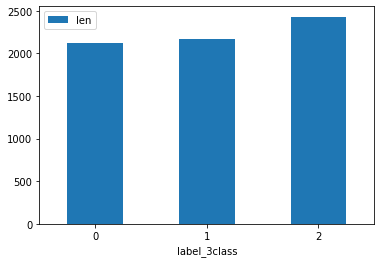

In [6]:
subj_len_df = df.copy()
subj_len_df['len'] = subj_len_df.subj.map(len)
c = subj_len_df[['label_3class','len']].groupby('label_3class').mean()
c.plot.bar(rot=0)

## Najczęściej występujące słowa:

### Wszystkie:

In [7]:
all_data_cv = CountVectorizer()
words_counts = all_data_cv.fit_transform(df.subj)
print('Różnych słów: ' + str(len(words_counts.toarray()[0])))
counts = pd.DataFrame(words_counts.toarray(),
                      columns=all_data_cv.get_feature_names())
counts.sum().T.sort_values(ascending=False).head(15).reset_index(name='counts')

Różnych słów: 41932


,index,counts
0,the,112685
1,of,55778
2,and,48379
3,to,44245
4,is,39599
5,it,32405
6,in,28737
7,that,25740
8,for,18343
9,as,17585


### Używając stop_words

In [8]:
all_data_cv = CountVectorizer(stop_words='english')
words_counts = all_data_cv.fit_transform(df.subj)
print('Różnych słów: ' + str(len(words_counts.toarray()[0])))
counts = pd.DataFrame(words_counts.toarray(),
                      columns=all_data_cv.get_feature_names())
counts.sum().T.sort_values(ascending=False).head(15).reset_index(name='counts')

Różnych słów: 41631


,index,counts
0,film,17304
1,movie,9601
2,like,6194
3,story,5363
4,director,3954
5,just,3849
6,time,3845
7,films,3453
8,characters,3240
9,good,3170


# System do maszynowego uczenia

In [9]:
subj_len_df = df.copy()
subj_len_df['len'] = subj_len_df.subj.map(len)

# X_data = subj_len_df[['subj', 'len']]
X_data = subj_len_df[['subj']]
y_data = subj_len_df.label_3class

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

In [10]:
v = CountVectorizer(stop_words='english')
X_train_count = v.fit_transform(X_train.subj.values)

In [11]:
X_test_count = v.transform(X_test.subj)

In [12]:
# print(X_train.head())
# print(X_train_count)
# print(type(X_test_count))
# print(pd.DataFrame.sparse.from_spmatrix(X_test_count))
# print(X_data.len.values)

In [13]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [14]:
model.predict(X_test_count)

array([1, 2, 1, ..., 2, 1, 2], dtype=int64)

In [15]:
model.score(X_test_count, y_test)

0.610223642172524

In [16]:
clf = svm.SVC()
clf.fit(X_train_count, y_train)

SVC()

In [17]:
predictions = clf.predict(X_test_count)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.30      0.43       302
           1       0.55      0.77      0.64       487
           2       0.74      0.71      0.73       463

    accuracy                           0.64      1252
   macro avg       0.69      0.60      0.60      1252
weighted avg       0.67      0.64      0.62      1252



In [18]:
clf.score(X_test_count, y_test)

0.6373801916932907

In [19]:
scores = cross_val_score(model, X_train_count, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean())

[0.60106383 0.58510638 0.62765957 0.59042553 0.61333333 0.64533333
 0.63466667 0.66666667 0.632      0.63466667]
0.6230921985815603


In [20]:
scores = cross_val_score(clf, X_train_count, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print(scores)
print(scores.mean())

[0.67287234 0.60106383 0.66755319 0.59840426 0.62133333 0.65066667
 0.61066667 0.64266667 0.60533333 0.62933333]
0.6299893617021277


In [21]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
grid.fit(X_train_count, y_train)

print(grid.best_params_)
print(grid.best_estimator_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)


In [22]:
grid_predictions = grid.predict(X_test_count)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.66      0.53      0.59       302
           1       0.57      0.69      0.62       487
           2       0.78      0.70      0.74       463

    accuracy                           0.66      1252
   macro avg       0.67      0.64      0.65      1252
weighted avg       0.67      0.66      0.66      1252

